# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')
df = pd.concat([train, test], sort=True).reset_index(drop=True)
print(len(train),len(test),len(submit),len(df))

891 418 418 1309


#### Check for null data

In [3]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

TODO:<br>
1) Only first class passengers can have a cabin, so cabin feature is not useful.
    However, the cabin letters could indicate what floor level each passenger is at. Cabin A is at the top, so it is closest to the deck where the lifeboats are. As a result, it could be useful to use Cabin letters. <br>

### Feature engineering and Feature Selection

In [4]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [5]:
# transform cabin column into holding only cabin floor
#df.loc[df['Cabin'].isna()==True,'Cabin'] = 'Z'
test.loc[test['Cabin'].isna()==True,'Cabin'] = 'Z'
train.loc[train['Cabin'].isna()==True,'Cabin'] = 'Z'
def split(word):
    return [char for char in word]

In [6]:
train['Cabin'] = [split(i) for i in train['Cabin']]
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Z']
a = []
for i in train['Cabin']:
    b = []
    for j in i:
        if j in cabin_list:
            b.append(j)
    a.append(b)
train['Cabin'] = a
# select the highest deck for passengers with multiple decks booked
train['Cabin'] = [min(i) for i in train['Cabin']]

test['Cabin'] = [split(i) for i in test['Cabin']]
a = []
for i in test['Cabin']:
    b = []
    for j in i:
        if j in cabin_list:
            b.append(j)
    a.append(b)
test['Cabin'] = a
test['Cabin'] = [min(i) for i in test['Cabin']]

In [7]:
train['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [8]:
train[(train['Parch']==0) & (train['Age'].isna()==True)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Z,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,Z,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,Z,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,Z,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Z,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C,C
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C,C
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,Z,C
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,Z,S


Most of the nan values for age can be solved using Parch

In [9]:
test.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin           0
Embarked        0
dtype: int64

#### "Some children travelled only with a nanny, therefore parch=0 for them" source kaggle variable notes

In [10]:
# Add column age range 
train['AgeRange'] = None
train.loc[train['Age']<13,'AgeRange'] = 'Child'
train.loc[(train['Age']>=13)&(train['Age']<21),'AgeRange'] = 'Teen'
train.loc[train['Age']>=21,'AgeRange'] = 'Adult'
train.loc[(train['Parch']==0)&(train['Age'].isna()==True),'AgeRange'] = 'Child'
train.loc[train['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'
# drop Age column
#train = train.drop(['Age'], axis=1) 
test['AgeRange'] = None
test.loc[test['Age']<13,'AgeRange'] = 'Child'
test.loc[(test['Age']>=13)&(test['Age']<21),'AgeRange'] = 'Teen'
test.loc[test['Age']>=21,'AgeRange'] = 'Adult'
test.loc[(test['Parch']==0)&(test['Age'].isna()==True),'AgeRange'] = 'Child'
test.loc[test['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'

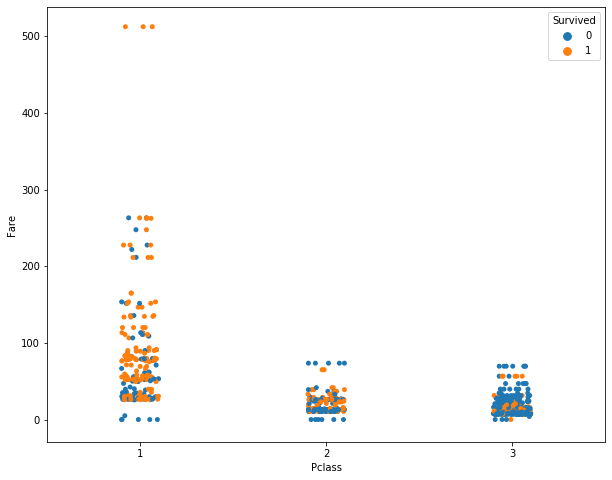

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
# check relation between fare price and Pclass
plt.figure(figsize=(10, 8))
sns.stripplot(x='Pclass',y='Fare',hue='Survived',data=train)
plt.show()

#### Observations:
1) Fare price does not relate to the ticket class unless fare is above 100 <br>
2) For fare above 100, 1st class has more % of survivers than that of 1st class tickets below 100 <br> 
2) 1st and 2nd class ticket holders have more survivers than 3rd class <br>

In [12]:
print(train.groupby('Survived')['Cabin'].value_counts().unstack().fillna(0))

Cabin       A     B     C     D     E    F    G    T      Z
Survived                                                   
0         8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1         7.0  35.0  35.0  25.0  25.0  7.0  2.0  0.0  206.0


It was expected that as Cabin number would increase from A to T the number of survived would decrease as lower letter Cabins are closer to the the deck (where life boats are). 

In [13]:
print(round(train.groupby('Cabin')['Fare'].mean()))
print(round(train.groupby('Cabin')['Fare'].median()))

Cabin
A     40.0
B    114.0
C    100.0
D     57.0
E     45.0
F     18.0
G     14.0
T     36.0
Z     19.0
Name: Fare, dtype: float64
Cabin
A    36.0
B    80.0
C    83.0
D    53.0
E    38.0
F    12.0
G    14.0
T    36.0
Z    10.0
Name: Fare, dtype: float64


Note: Cabin Z is 2nd and 3rd class <br>
#### Observations:
1) looking at the mean and median fare for each cabin, and comparing it to the Survived count table, Cabin B,C and D are most expensive cabins and they also have the highest Survival rate. <br>
2) Since fare value is significant to 5 decimal places using it will make the model too complex. To simplify model building, either use a similified version of fare value or use cabin column and fare column to create a new feature.

In [14]:
# add feature avg price of a cabin (calculated as int)
avg = round(train.groupby('Cabin')['Fare'].mean())
avg = {j:i for i,j in zip(avg,train['Cabin'].unique())}
train['Fare_avg'] = [avg[i] for i in train['Cabin']]

avg = round(test.groupby('Cabin')['Fare'].mean())
avg = {j:i for i,j in zip(avg,test['Cabin'].unique())}
test['Fare_avg'] = [avg[i] for i in test['Cabin']]

In [15]:
print(train.groupby('Survived')['Embarked'].value_counts().unstack().fillna(0))

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


In [16]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']
a = [i.strip().split() for i in train['Name']]
a = [j for i in a for j in i if '.' in j]
a = pd.DataFrame(a)
a[0].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Jonkheer.      1
Sir.           1
Don.           1
Ms.            1
Capt.          1
Lady.          1
Countess.      1
Mme.           1
L.             1
Name: 0, dtype: int64

In [17]:
a = a[a[0]!='L.']
train['Title'] = a

In [18]:
train[train['Title'].isna()==True][['Name','Title']]

,Name,Title
514,"Coleff, Mr. Satio",NaN


In [19]:
train.loc[514,'Title'] = 'Mr.'
#train.loc[890,'Title'] = 'Mr.'

In [20]:
a = [i.strip().split() for i in test['Name']]
a = [j for i in a for j in i if '.' in j]
a = pd.DataFrame(a)
a[0].value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dona.        1
Dr.          1
Name: 0, dtype: int64

In [21]:
test['Title'] = a[a[0]!='Dona.']

In [22]:
test[test['Title'].isna()==True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeRange,Fare_avg,Title
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C,C,Adult,71.0,NaN


In [23]:
# assume it is Ms
test.loc[414,'Title'] = 'Ms.'

### one hot encoding

In [24]:
# simplify code using encode = ['Sex','AgeRange','Cabin']
dummies = pd.get_dummies(train.Sex)
for i in train['Sex'].unique():
    train[i] = 0
for i in train['Sex'].unique():
    train.loc[:,i] =  dummies[i]
#train = train.drop(['Sex'], axis=1) 
train.head()
dummies = pd.get_dummies(test.Sex)
for i in test['Sex'].unique():
    test[i] = 0
for i in test['Sex'].unique():
    test.loc[:,i] =  dummies[i]

#test = test.drop(['Sex'], axis=1) 

In [25]:
# one hot encoding for age
dummies = pd.get_dummies(train.AgeRange)
for i in train['AgeRange'].unique():
    train[i] = 0
for i in train['AgeRange'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.AgeRange)
for i in test['AgeRange'].unique():
    test[i] = 0

for i in test['AgeRange'].unique():
    test.loc[:,i] =  dummies[i]

In [26]:
# one hot encoding for Cabin
dummies = pd.get_dummies(train.Cabin)
for i in train['Cabin'].unique():
    train[i] = 0
for i in train['Cabin'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.Cabin)
for i in test['Cabin'].unique():
    test[i] = 0

for i in test['Cabin'].unique():
    test.loc[:,i] =  dummies[i]

In [27]:
# one hot encoding for Title
dummies = pd.get_dummies(train.Title)
for i in train['Title'].unique():
    train[i] = 0
for i in train['Title'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.Title)
for i in test['Title'].unique():
    test[i] = 0

for i in test['Title'].unique():
    test.loc[:,i] =  dummies[i]

In [28]:
train[train['Embarked'].isna()==True][['Name','Sex','Ticket','Embarked','Cabin']]

,Name,Sex,Ticket,Embarked,Cabin
61,"Icard, Miss. Amelie",female,113572,NaN,B
829,"Stone, Mrs. George Nelson (Martha Evelyn)",female,113572,NaN,B


 After google one of the passengers (https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) found that the Embarked value is 'S' since the other passenger has the same ticket number means they travelled together and so both Embarked from the same location

In [29]:
train['Embarked'] = train['Embarked'].fillna('S')

In [30]:
# one hot encoding for Embarked
dummies = pd.get_dummies(train.Embarked)
for i in train['Embarked'].unique():
    train[i+'E'] = 0
for i in train['Embarked'].unique():
    train.loc[:,i+'E'] =  dummies[i]
    
dummies = pd.get_dummies(test.Embarked)
for i in test['Embarked'].unique():
    test[i+'E'] = 0

for i in test['Embarked'].unique():
    test.loc[:,i+'E'] =  dummies[i]

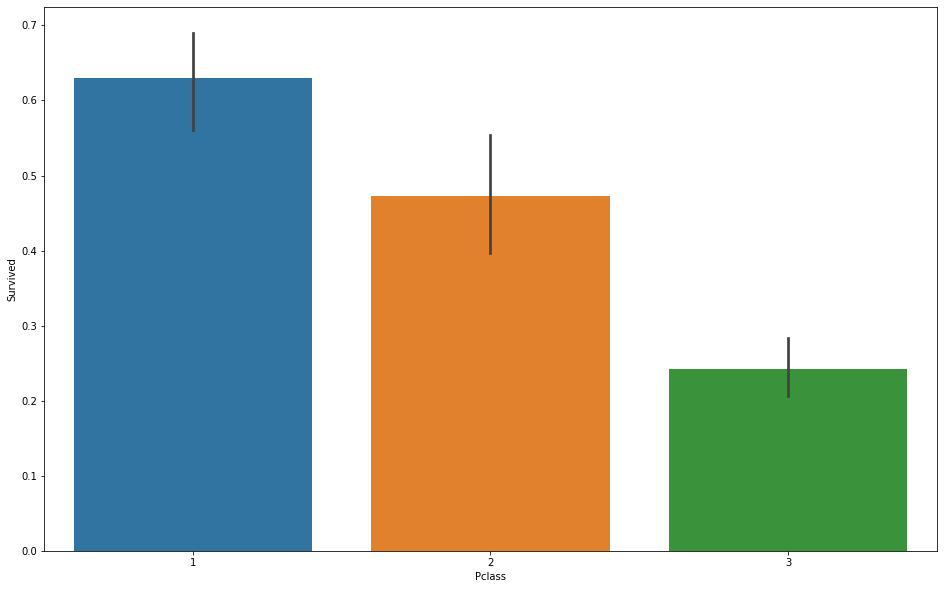

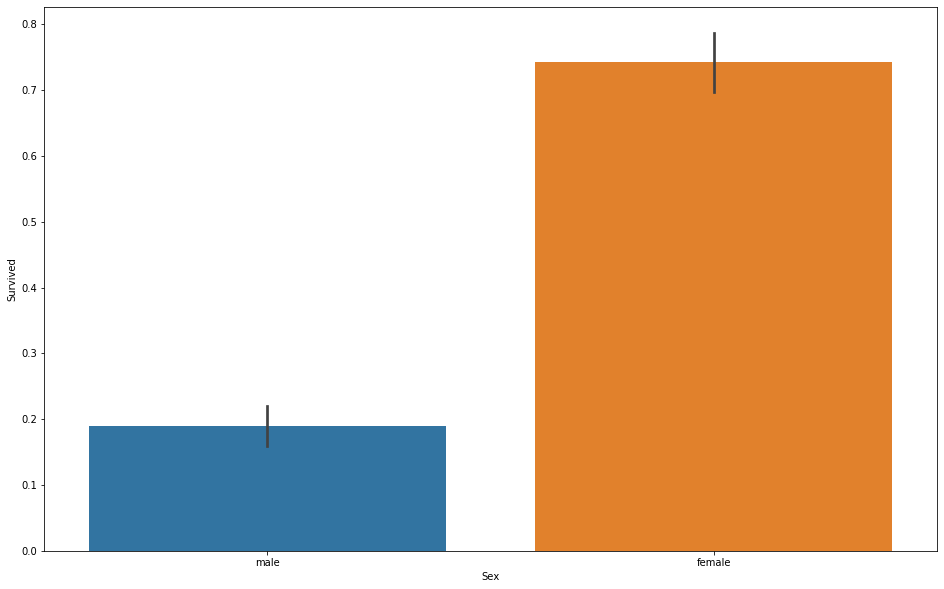

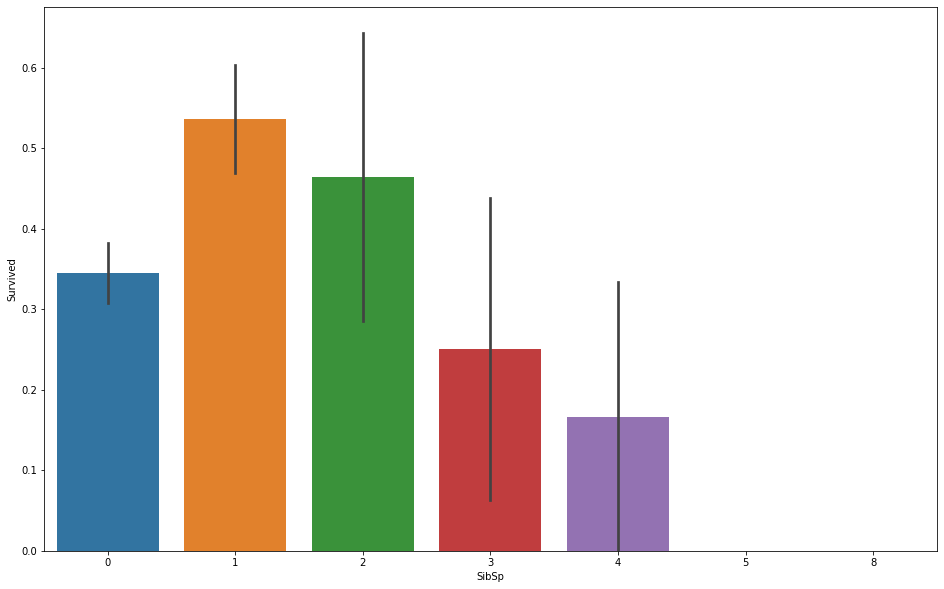

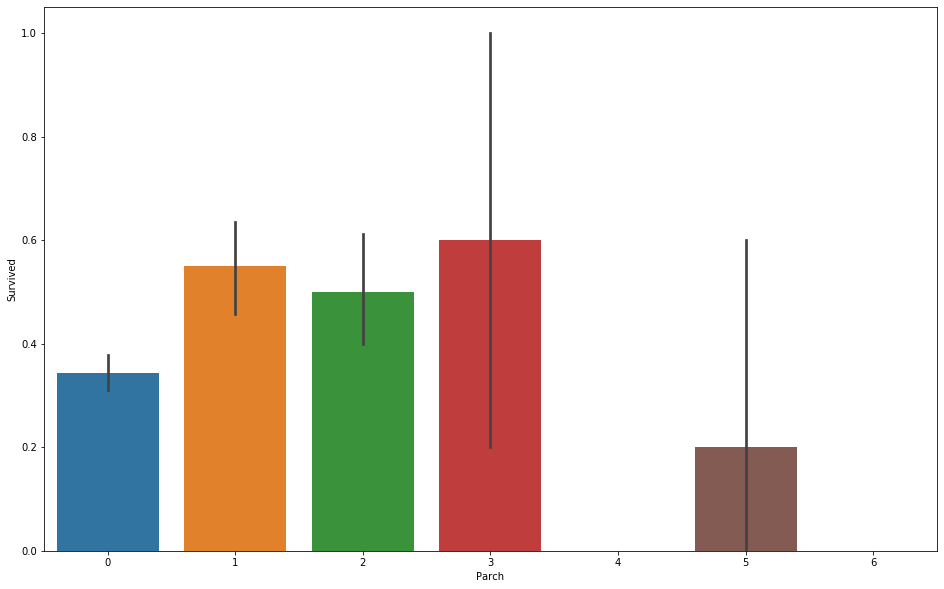

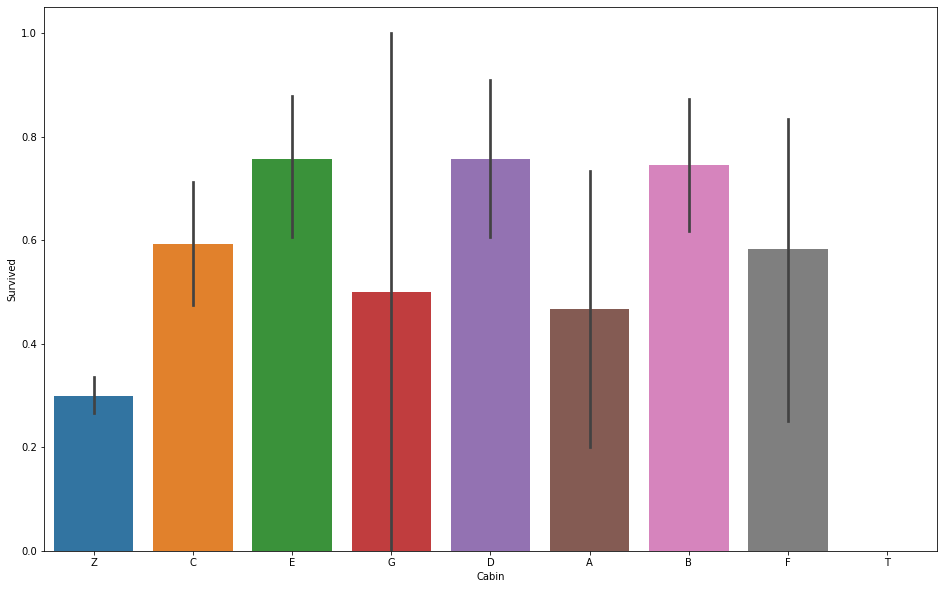

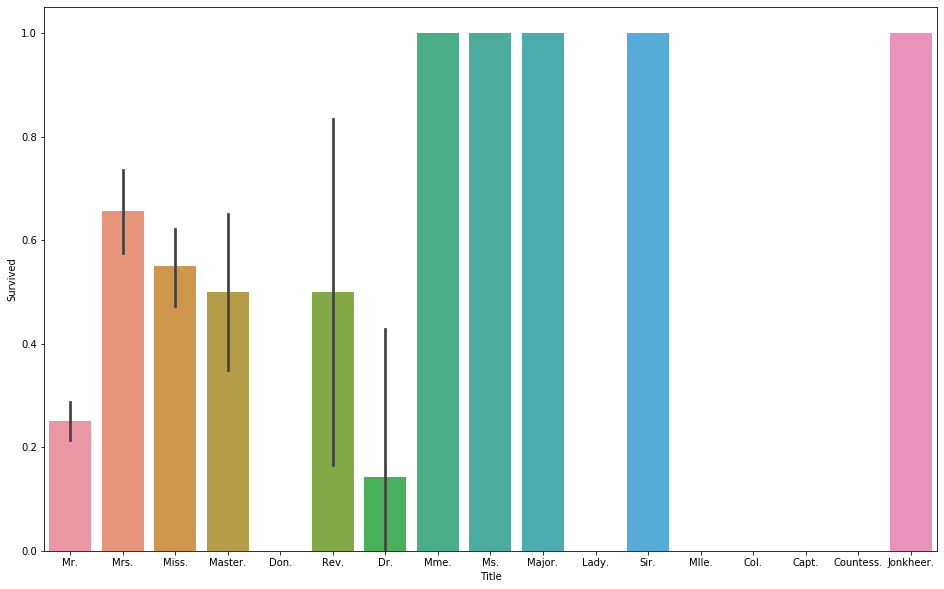

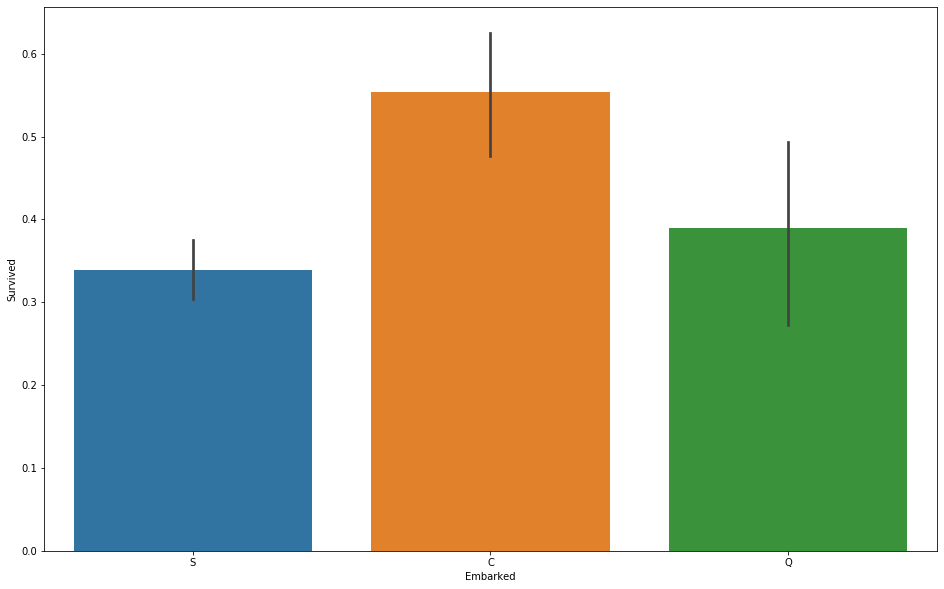

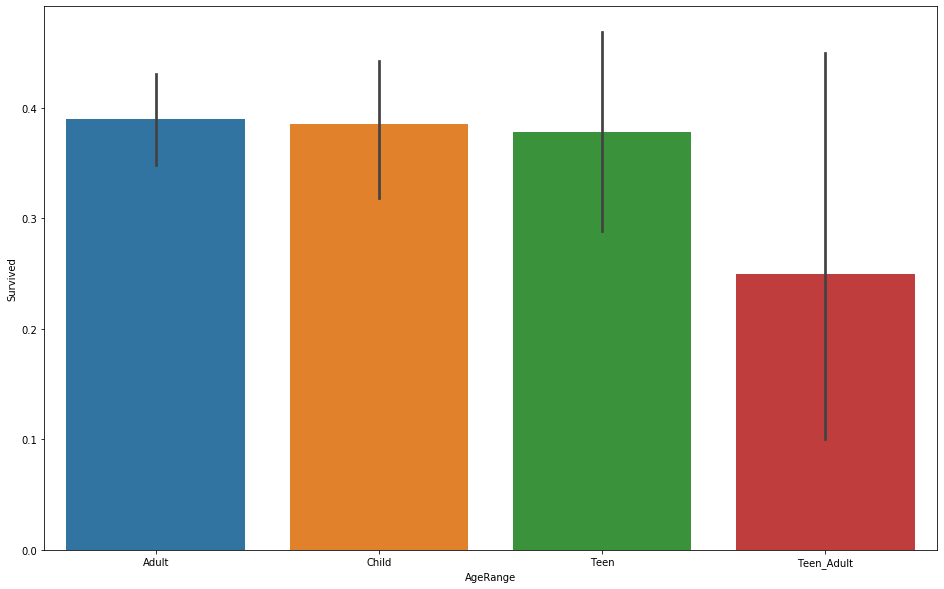

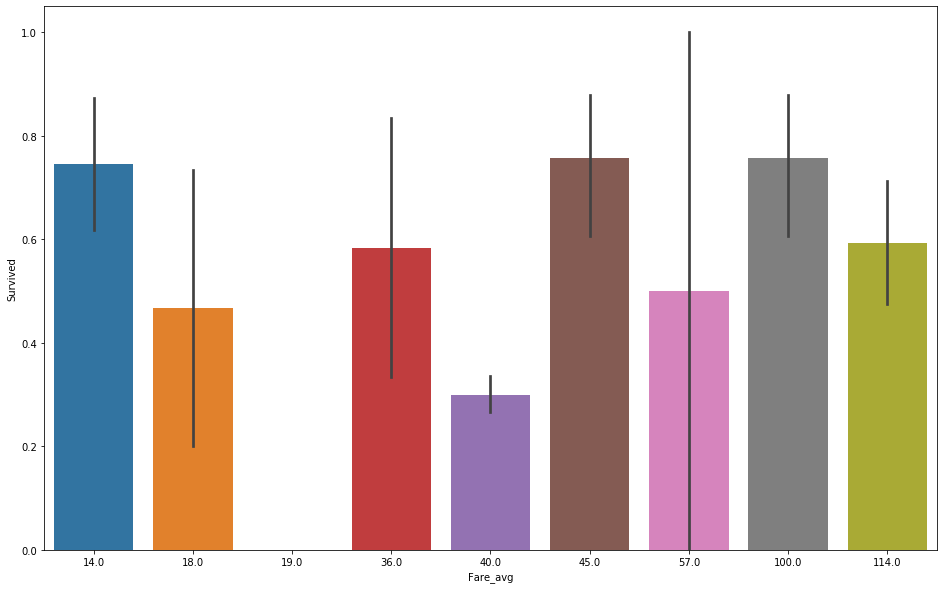

In [31]:
for i in ['Pclass', 'Sex', 'SibSp',
          'Parch', 'Cabin', 'Title',
          'Embarked', 'AgeRange', 'Fare_avg']:
    plt.figure(figsize=(16, 10))
    sns.barplot(x=i,y='Survived',data=train)
    plt.show()

## Model

In [32]:
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
#import graphviz
from sklearn.metrics import confusion_matrix

In [33]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeRange', 'Fare_avg',
       'Title', 'male', 'female', 'Adult', 'Child', 'Teen', 'Teen_Adult', 'Z',
       'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T', 'Mr.', 'Mrs.', 'Miss.',
       'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'Lady.',
       'Sir.', 'Mlle.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.', 'SE', 'CE',
       'QE'],
      dtype='object')

In [34]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeRange', 'Fare_avg', 'Title',
       'male', 'female', 'Adult', 'Teen', 'Child', 'Teen_Adult', 'Z', 'B', 'E',
       'A', 'C', 'D', 'F', 'G', 'Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.',
       'Col.', 'Rev.', 'Dr.', 'QE', 'SE', 'CE'],
      dtype='object')

### Since this is a classification problem we can use D-Trees or random forest if this does not increase the acuracy from the baseline score then we can try other classification models

In [35]:
train = train.sample(frac=1).reset_index(drop=True)

clf = tree.DecisionTreeClassifier()
features = ['Pclass','SibSp','Parch','male','Child',
            'Adult','Teen','Teen_Adult','Z','C','B',
            'D','E', 'SE', 'CE', 'QE','Mr.', 'Mrs.', 
            'Miss.', 'Master.', 'Ms.','Col.', 'Rev.', 'Dr.']
X = train[features]
Y = train['Survived']
clf = clf.fit(X, Y)

#### Reason for feature selection:

In [36]:
# predict which passengers survived using the trained model
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_dt1.csv', index=False)

In [37]:
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

male          0.419191
Pclass        0.126008
SibSp         0.089838
Parch         0.072952
Z             0.048764
CE            0.027570
Mr.           0.026646
SE            0.025887
Teen          0.019472
Master.       0.019471
Miss.         0.018869
Child         0.017300
Mrs.          0.015622
E             0.015349
C             0.014561
Adult         0.012078
D             0.011318
Teen_Adult    0.008473
QE            0.005819
Dr.           0.003177
B             0.001075
Rev.          0.000561
Ms.           0.000000
Col.          0.000000
dtype: float64

### Decision tree is a base line model with a score of 75.60% accuracy (score from kaggle)
#### To improve from base score do parameter tunning for decision tree and also make a model for random forest

In [38]:
# shuffle
train = train.sample(frac=1).reset_index(drop=True)

train_val_X = train[features]
train_val_y = train['Survived']

print(len(train), len(test))
print(len(train_val_X),len(train_val_y))

891 418
891 891


Depth:  1
Training accuracy:  78.67548103440126 %
Validation accuracy:  78.6730274307953 %
Depth:  5
Training accuracy:  84.00684715634208 %
Validation accuracy:  79.57441466323519 %
Depth:  6
Training accuracy:  84.96072143341159 %
Validation accuracy:  79.57441466323519 %
Depth:  7
Training accuracy:  86.19506122256014 %
Validation accuracy:  80.13558470905781 %
Depth:  8
Training accuracy:  87.28938493783191 %
Validation accuracy:  79.46079969870065 %
Depth:  9
Training accuracy:  88.24345619868573 %
Validation accuracy:  80.35779298223589 %
Depth:  10
Training accuracy:  88.74852262161778 %
Validation accuracy:  79.46268281965978 %
Depth:  11
Training accuracy:  89.30965062956015 %
Validation accuracy:  79.57504237022158 %
Depth:  12
Training accuracy:  89.70251508895787 %
Validation accuracy:  79.9114933149206 %
Depth:  13
Training accuracy:  90.03919977307469 %
Validation accuracy:  79.57378695624882 %
Depth:  14
Training accuracy:  90.29177238129756 %
Validation accuracy:  79.01

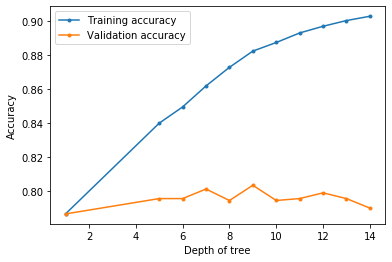

In [39]:
def dtc_parameter_tune(tain_val_X, train_val_y):
    depths = [1,5,6,7,8,9,10,11,12,13,14]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X.iloc[train_index,:]
            val_X = train_val_X.iloc[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = tree.DecisionTreeClassifier(max_depth=depth,random_state=0,
                                              criterion='entropy')
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            
        avg_train_acc = sum(train_acc) / len(train_acc) # compute the average training accuracy of K-folds CV
        avg_val_acc = sum(val_acc) / len(val_acc) # compute the average validation accuracy of K-folds CV
        print("Depth: ", depth)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X,train_val_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

In [40]:
best_index = val_acc_all.index(max(val_acc_all))
best_depth = depths[best_index]
dtc = tree.DecisionTreeClassifier(max_depth=best_depth,random_state=0,
                                  criterion='entropy')
dtc.fit(train_val_X,train_val_y)
train_acc = dtc.score(train_val_X, train_val_y)

print("Best depth: ", best_depth)
print("Training accuracy: ", train_acc * 100, "%")
print("mean accuracy", np.mean(val_acc_all)* 100, "%")

Best depth:  9
Training accuracy:  87.99102132435466 %
mean accuracy 79.57384402052031 %


In [41]:
# predict which passengers survived using the trained model
submit['Survived'] = dtc.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_dt_tuned.csv', index=False)

### Decision tree with tuned parameter is 78.89% accuracy (score from kaggle)

In [42]:
feature_imp = pd.Series(dtc.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

male          0.392132
Pclass        0.133647
SibSp         0.091270
Parch         0.060434
Z             0.057723
Child         0.043145
CE            0.038039
Master.       0.026627
SE            0.024577
Mrs.          0.021043
Mr.           0.017396
E             0.017307
Miss.         0.014447
D             0.011613
C             0.009574
QE            0.009476
Teen_Adult    0.008919
Teen          0.006519
B             0.005862
Adult         0.005587
Dr.           0.004664
Rev.          0.000000
Ms.           0.000000
Col.          0.000000
dtype: float64

Estimator:  1
Training accuracy:  86.25092582378619 %
Validation accuracy:  78.67679367271357 %
Estimator:  2
Training accuracy:  86.41966213341318 %
Validation accuracy:  76.0962902517105 %
Estimator:  3
Training accuracy:  88.49606820366547 %
Validation accuracy:  78.56506182913816 %
Estimator:  4
Training accuracy:  88.60834896071357 %
Validation accuracy:  78.11687904086371 %
Estimator:  5
Training accuracy:  89.4780717651323 %
Validation accuracy:  78.22672776348001 %
Estimator:  6
Training accuracy:  89.36594859511166 %
Validation accuracy:  78.56317870817901 %
Estimator:  7
Training accuracy:  89.8710150180437 %
Validation accuracy:  79.12372104701525 %
Estimator:  8
Training accuracy:  89.73068377011204 %
Validation accuracy:  79.34781244115247 %
Estimator:  9
Training accuracy:  90.01126747246167 %
Validation accuracy:  79.12434875400164 %
Estimator:  10
Training accuracy:  90.01138566273225 %
Validation accuracy:  79.34844014813883 %
Estimator:  11
Training accuracy:  90.1516

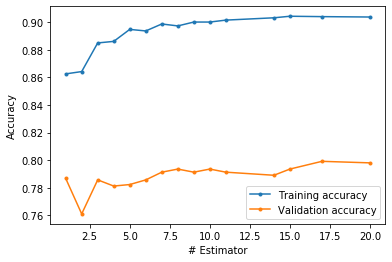

In [43]:
def clf_parameter_tune(tain_val_X, train_val_y):
    n_estimators = [1,2,3,4,5,6,7,8,9,10,11,14,15,17,20]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for estimator in n_estimators:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X.iloc[train_index,:]
            val_X = train_val_X.iloc[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            clf = RandomForestClassifier(n_estimators=estimator,random_state=0,
                                         criterion='entropy')
            clf.fit(train_X, train_y)
            train_acc.append(clf.score(train_X, train_y))
            val_acc.append(clf.score(val_X, val_y))
            
        avg_train_acc = sum(train_acc) / len(train_acc) # compute the average training accuracy of K-folds CV
        avg_val_acc = sum(val_acc) / len(val_acc) # compute the average validation accuracy of K-folds CV
        print("Estimator: ", estimator)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return n_estimators, train_acc_all, val_acc_all

n_estimators, train_acc_all, val_acc_all = clf_parameter_tune(train_val_X, train_val_y)

# plot training/validation curves
plt.plot(n_estimators, train_acc_all, marker='.', label="Training accuracy")
plt.plot(n_estimators, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('# Estimator')
plt.ylabel('Accuracy')
plt.legend()

In [44]:
best_index = val_acc_all.index(max(val_acc_all))
best_estimator = n_estimators[best_index]
clf = RandomForestClassifier(n_estimators=best_estimator,random_state=0,
                             criterion='entropy')
clf.fit(train_val_X,train_val_y)
train_acc = clf.score(train_val_X, train_val_y)

print("Best estimator: ", best_estimator)
print("Training accuracy: ", train_acc * 100, "%")
print("mean accuracy", np.mean(val_acc_all)* 100, "%")

Best estimator:  17
Training accuracy:  89.67452300785635 %
mean accuracy 78.81802774464879 %


In [45]:
# predict which passengers survived using the trained model
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_RF_tuned.csv', index=False)

### Result of random forest was 76.63%, need to do more parameter tuning for RF to imporve score

In [46]:
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

male          0.269923
SibSp         0.126941
Pclass        0.119537
Parch         0.086114
Z             0.051239
Mr.           0.048160
Mrs.          0.032916
Adult         0.029832
Child         0.029701
SE            0.023525
CE            0.022958
Miss.         0.022939
E             0.021418
B             0.018540
Teen          0.018514
Master.       0.017891
C             0.017213
QE            0.014886
D             0.013061
Teen_Adult    0.007561
Dr.           0.004462
Rev.          0.001745
Ms.           0.000602
Col.          0.000321
dtype: float64

#### add boosting and ada boost model

In [47]:
# TODO: add tunning`
from sklearn.ensemble import AdaBoostClassifier
train = train.sample(frac=1).reset_index(drop=True)
X = train[features]
y = train['Survived']
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
print(clf.score(X, y))
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_ADA_tuned.csv', index=False)

0.8170594837261503


In [48]:
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

Parch         0.45
Pclass        0.14
Z             0.06
male          0.05
SibSp         0.04
E             0.03
D             0.03
Mr.           0.02
QE            0.02
Master.       0.02
Teen_Adult    0.02
Dr.           0.02
SE            0.02
Rev.          0.01
B             0.01
C             0.01
Mrs.          0.01
Adult         0.01
Child         0.01
Ms.           0.01
Col.          0.01
Teen          0.00
CE            0.00
Miss.         0.00
dtype: float64